In [1]:
""" 
Basic tools for exploring and understanding the monkey drawing data
You will need:
- dataset, at https://www.dropbox.com/s/dl8vxw7iav2up8k/data.zip?dl=0
-- data.zip contains two datasets (2 monkeys). the example code below is looking at one monkey at a time.
- pythonlib (https://github.com/lucast4/pythonlib
- pandas, seaborn, and other common packages.

Slides that summarize the experiment, motivation, and findings:
https://docs.google.com/presentation/d/1pg0YQxiqQS9mwe_kU_bcfiIytE4mTc0Xhtz4wISSoE0/edit?usp=sharing (detailed)
https://docs.google.com/presentation/d/1xny1pfSBV9HQJOuxs9WaX6CPvg8qMlfuwMqOMGcSK2g/edit?usp=sharing (concise)
"""


' \nBasic tools for exploring and understanding the monkey drawing data\nYou will need:\n- dataset, at https://www.dropbox.com/s/dl8vxw7iav2up8k/data.zip?dl=0\n-- data.zip contains two datasets (2 monkeys). the example code below is looking at one monkey at a time.\n- pythonlib (https://github.com/lucast4/pythonlib\n- pandas, seaborn, and other common packages.\n'

In [2]:
import pandas as pd
import pickle 

# Load
SDIR = "/data2/analyses/database/Red-lines5-formodeling-210309_102050"

dat = pd.read_pickle(f"{SDIR}/dat.pkl")
with open(f"{SDIR}/metadat.pkl", "rb") as f:
    metadat = pickle.load(f)


## BASICS

In [3]:
# each row of dat is a trial (a single image + behavior).

# - motor behavior is saved in "strokes_beh"
# - stroke_beh is a list of np arrays, each array is shape (N, 3), where N is number timepoints and
# 3 is (x, y, t) coordiantes. x and y are in pixels (centered at 0) and t is seconds rel trial onset.
# - len(strokes_beh) tells you how many independent segments were in the motor behavior (i.e,., each segment
# is touch --> draw --> lift.
trial = 50
# print(dat["strokes_beh"][trial])
print("num segmetns in this trial:")
print(len(dat["strokes_beh"][trial]))


# -Stimuli are saved in the exact same way, except the order of segments is meaningless
# and is therefore arbitrary. there is a still a time coordinate, but it is just indices from 0, 1, ..
print("task stimulus")
print(dat["strokes_task"][trial])



num segmetns in this trial:
2
task stimulus
[array([[197.04488001, 179.71486519,   0.        ],
       [193.42447334, 183.93862643,   1.        ],
       [189.80406667, 188.16238766,   2.        ],
       [186.18366001, 192.38614889,   3.        ],
       [182.56325334, 196.60991013,   4.        ],
       [178.94284667, 200.83367136,   5.        ],
       [175.32244   , 205.0574326 ,   6.        ],
       [171.70203334, 209.28119383,   7.        ],
       [168.08162667, 213.50495506,   8.        ],
       [164.46122   , 217.7287163 ,   9.        ],
       [160.84081333, 221.95247753,  10.        ],
       [157.22040667, 226.17623877,  11.        ],
       [153.6       , 230.4       ,  12.        ],
       [149.97959333, 234.62376123,  13.        ],
       [146.35918667, 238.84752247,  14.        ],
       [142.73878   , 243.0712837 ,  15.        ],
       [139.11837333, 247.29504494,  16.        ],
       [135.49796666, 251.51880617,  17.        ],
       [131.87756   , 255.7425674 ,  

## DATA VISYUALIZATION (motor data)

- Helper functions to visualize the mtoor and stim data

(-165.00278528025507, 167.99762276138011)

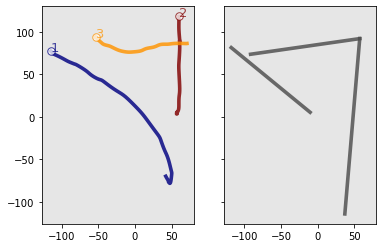

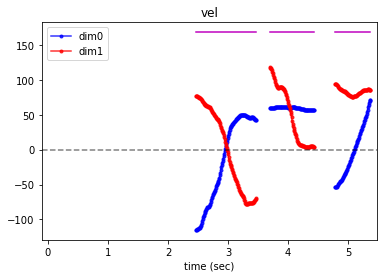

In [4]:
import matplotlib.pyplot as plt
from pythonlib.drawmodel.strokePlots import plotDatStrokes, plotDatStrokesTimecourse, plotDatWaterfall

# === Plot a single trial
idx = 100
fig, axes = plt.subplots(1,2, sharex=True, sharey=True)

# Plot behavior for this trial
# - the ball marks stroke onset. stroke orders are color coded, and also indicated by numbers.
strokes = dat["strokes_beh"][idx]
plotDatStrokes(strokes, axes[0], each_stroke_separate=True)

# overlay the stimulus
stim = dat["strokes_task"][idx]
plotDatStrokes(stim, axes[1], each_stroke_separate=True, plotver="onecolor", add_stroke_number=False, mark_stroke_onset=False, pcol="k")


# === Plot motor timecourse for a single trial (smoothed velocity vs. time)
fig, axes = plt.subplots(1,1, sharex=True, sharey=True)
plotDatStrokesTimecourse(strokes, axes, plotver="vel", label="vel (pix/sec)")



## EXPERIEMNTAL STRUCTURE/TIMELINE
There are two epochs, each epoch having its set of training and tests tasks. 

Across days, it goes like this:
Epoch 1 (Train) --> Epoch 1 (Test) --> Epoch 2 (Train) --> Epoch 2 (Test)

Ideally, you train seprate models for Epochs 1 and 2, since the idea is that the monkey is laerning different

Priors in the two epochs (Train) then being tested on similar test tasks (Test).

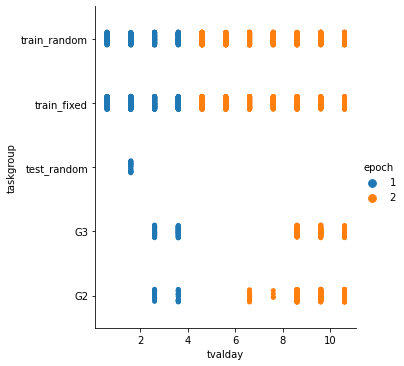

In [5]:
# To visualize the experimental structure:
# notes:
# - tvalday is time of trial. e..g, the first digit is the day, the value after decimal is fraction of day (not
# exactly from midnight to midnight, but within the "experimental session"). so 2.5 means day 1, halfway through the 
# day (from start of expt to end of expt)
# - to get the actual time, see "tval" qwhich is fraction of day from 0:00 to 24:00

import seaborn as sns
sns.catplot(data=dat, x="tvalday", y="taskgroup", hue="epoch")

## TO SPLIT INTO TRAINING VS. TEST TASKS
Training tasks have taskgroup = "train_random" or "train_fixed"

Test tasks have taskgroup:

"G2" - "interpolation" tests

"G3" - "extrapolation" test tasks

In [6]:
# Check and print sample sizes.
for t in set(dat["taskgroup"]):
    print("--")
    print(t)
    print(sum(dat["taskgroup"]==t))
    
    
# For convenience, add column for whether task is train or test.
from pythonlib.tools.pandastools import applyFunctionToAllRows

def F(x):
    if x["taskgroup"] in ["train_fixed", "train_random"]:
        return "train"
    elif x["taskgroup"] in ["G2", "G3", "test_random"]:
        return "test"
    else:
        print(x)
        assert False, "huh"
dat = applyFunctionToAllRows(dat, F, "train_or_test")


# Fro exampel, extract training tasks for epoch 1
train_or_test = "train"
epoch = 1
datthis = dat[(dat["epoch"]==epoch) & (dat["train_or_test"]==train_or_test)]
print(len(datthis))

--
G2
420
--
train_random
2043
--
train_fixed
2799
--
G3
309
--
test_random
28
1894


## normalizing units for data and images


In [7]:
# This holds the edges of sketchpad, in same units as data (pixels), in format:
# [[-x, -y], [+x +y]], i..e, the limits of the "sketchpad". 
# - You can normalize units relative to these bounds, if needed
metadat["sketchpad_edges"]

array([[-327.2, -327.2],
       [ 327.2,  429.6]])